# Load in the Dataset + Packages

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

In [2]:
# Load data from excel
api_df = pd.read_excel("../../data/raw/train_essentials.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]

In [5]:
y_train.value_counts()

Medium    661
Low       651
High        4
Name: Risk_Label, dtype: int64

In [6]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [7]:
# Balance training data
X_train, y_train = create_smote(X_train, y_train, 2)

# Helper Code

In [8]:
results = {}
scoring_metric = ["accuracy", "f1_macro", "recall_macro"]

In [9]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# Baseline Performance

In [10]:
# Dummy Classifier Model
model_dummy = DummyClassifier(strategy="stratified", random_state=42)
results["Dummy"] = mean_std_cross_val_scores(
    model_dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy
fit_time,0.006 (+/- 0.008)
score_time,0.012 (+/- 0.004)
test_accuracy,0.342 (+/- 0.019)
train_accuracy,0.331 (+/- 0.010)
test_f1_macro,0.342 (+/- 0.019)
train_f1_macro,0.331 (+/- 0.010)
test_recall_macro,0.342 (+/- 0.019)
train_recall_macro,0.331 (+/- 0.010)


In [11]:
# KNN Classifier Model
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
results["KNN"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN
fit_time,0.006 (+/- 0.008),0.031 (+/- 0.029)
score_time,0.012 (+/- 0.004),0.121 (+/- 0.036)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.010)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.010)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003)


In [12]:
# SVM Classifier Model
pipe_svm = make_pipeline(StandardScaler(), SVC(gamma=0.01))
results["SVM"] = mean_std_cross_val_scores(
    pipe_svm, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM
fit_time,0.006 (+/- 0.008),0.031 (+/- 0.029),0.166 (+/- 0.047)
score_time,0.012 (+/- 0.004),0.121 (+/- 0.036),0.068 (+/- 0.040)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003)


In [13]:
# Logistic Regression Classifier Model
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
results["LR"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR
fit_time,0.006 (+/- 0.008),0.031 (+/- 0.029),0.166 (+/- 0.047),0.118 (+/- 0.049)
score_time,0.012 (+/- 0.004),0.121 (+/- 0.036),0.068 (+/- 0.040),0.014 (+/- 0.002)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000)


# Hyperparameter Optimization

In [14]:
# Hyperparameter search for LogisticRegression
param_grid = {"logisticregression__C": [100, 10, 1.0, 0.1, 0.01],
             "logisticregression__solver": ['newton-cg', 'lbfgs', 'liblinear']}

grid_search = GridSearchCV(
    pipe_lr, param_grid, cv=20, n_jobs=-1, return_train_score=True
)
results_gs = grid_search.fit(X_train, y_train)

In [15]:
grid_search.best_score_

0.9954646464646466

In [16]:
grid_search.best_params_

{'logisticregression__C': 100, 'logisticregression__solver': 'liblinear'}

In [17]:
# Hyperparameter search for KNN
results_dict = {
    "n_neighbors": [],
    "mean_train_score": [],
    "mean_cv_score": [],
    "std_cv_score": [],
    "std_train_score": [],
}
param_grid = {"n_neighbors": np.arange(5, 500, 5)}

for k in param_grid["n_neighbors"]:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, return_train_score=True)
    results_dict["n_neighbors"].append(k)

    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))
    results_dict["std_cv_score"].append(scores["test_score"].std())
    results_dict["std_train_score"].append(scores["train_score"].std()) 

results_df = pd.DataFrame(results_dict)

<AxesSubplot:xlabel='n_neighbors'>

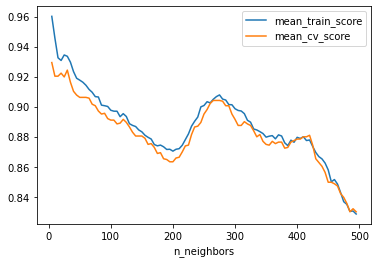

In [18]:
results_df.plot(x="n_neighbors", y=["mean_train_score", "mean_cv_score"])

In [19]:
results_df["train_cv_diff"] = results_df["mean_train_score"] - results_df["mean_cv_score"] 
results_df.head(20)

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score,train_cv_diff
0,5,0.960161,0.929386,0.015449,0.002886,0.030776
1,10,0.945663,0.920309,0.013482,0.007164,0.025354
2,15,0.932552,0.920319,0.007099,0.003037,0.012233
3,20,0.930787,0.922335,0.006509,0.005503,0.008451
4,25,0.934443,0.919811,0.012742,0.003476,0.014631
5,30,0.933560,0.924357,0.009296,0.003154,0.009203
6,35,0.929652,0.916289,0.010979,0.002880,0.013364
7,40,0.923349,0.910238,0.011653,0.003135,0.013111
8,45,0.918936,0.907723,0.009835,0.003178,0.011213
9,50,0.917674,0.906204,0.010248,0.004727,0.011470


# Performance of Optimized Models

In [20]:
# KNN classifier with n_neighbors=20
k = 20
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
results["KNN_tuned"] = mean_std_cross_val_scores(
    pipe_knn, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned
fit_time,0.006 (+/- 0.008),0.031 (+/- 0.029),0.166 (+/- 0.047),0.118 (+/- 0.049),0.016 (+/- 0.002)
score_time,0.012 (+/- 0.004),0.121 (+/- 0.036),0.068 (+/- 0.040),0.014 (+/- 0.002),0.071 (+/- 0.005)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003),0.850 (+/- 0.022)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003),0.849 (+/- 0.022)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000),0.877 (+/- 0.008)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003),0.850 (+/- 0.022)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008)


In [21]:
# Logistic Regression Classifier Model
pipe_lr_tuned = make_pipeline(StandardScaler(), LogisticRegression(C=100.0, solver='liblinear'))
results["LR_tuned"] = mean_std_cross_val_scores(
    pipe_lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring_metric
)
pd.DataFrame(results)

,Dummy,KNN,SVM,LR,KNN_tuned,LR_tuned
fit_time,0.006 (+/- 0.008),0.031 (+/- 0.029),0.166 (+/- 0.047),0.118 (+/- 0.049),0.016 (+/- 0.002),0.127 (+/- 0.011)
score_time,0.012 (+/- 0.004),0.121 (+/- 0.036),0.068 (+/- 0.040),0.014 (+/- 0.002),0.071 (+/- 0.005),0.015 (+/- 0.001)
test_accuracy,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003),0.850 (+/- 0.022),0.994 (+/- 0.004)
train_accuracy,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008),0.999 (+/- 0.001)
test_f1_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003),0.849 (+/- 0.022),0.994 (+/- 0.004)
train_f1_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000),0.877 (+/- 0.008),0.999 (+/- 0.001)
test_recall_macro,0.342 (+/- 0.019),0.906 (+/- 0.010),0.980 (+/- 0.006),0.995 (+/- 0.003),0.850 (+/- 0.022),0.994 (+/- 0.004)
train_recall_macro,0.331 (+/- 0.010),0.945 (+/- 0.003),0.989 (+/- 0.003),0.999 (+/- 0.000),0.878 (+/- 0.008),0.999 (+/- 0.001)
